In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from layers.noisy_bn import NoisyBatchNormalization
from models.fashion_mnist import get_model

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images = np.expand_dims(train_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)

In [4]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center = True,
    featurewise_std_normalization = True,
#     rotation_range=10,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.1,
#     zoom_range=0.1,
    horizontal_flip=True,)

val_datagen = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center = True,
    featurewise_std_normalization = True)

train_datagen.fit(train_images)
# val_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

val_datagen.mean = train_datagen.mean
val_datagen.std = train_datagen.std

In [5]:
train_gen = train_datagen.flow(train_images, to_categorical(train_labels), batch_size=100)
val_gen = val_datagen.flow(test_images, to_categorical(test_labels), shuffle=False, batch_size=100)

In [14]:
# model 1
tf.keras.backend.clear_session()
# input_node = keras.layers.Input((28,28,1,))

# conv1 = keras.layers.Conv2D(32, (3,3),activation='relu')(input_node)
# batch1 = keras.layers.BatchNormalization()(conv1)
# pool1 = keras.layers.MaxPool2D((2,2))(batch1)

# conv2 = keras.layers.Conv2D(128, (3,3),activation='relu')(pool1)
# batch2 = keras.layers.BatchNormalization()(conv2)
# pool2 = keras.layers.MaxPool2D((2,2))(batch2)

# conv3 = keras.layers.Conv2D(256, (3,3),activation='relu')(pool2)
# batch3 = keras.layers.BatchNormalization()(conv3)
# pool3 = keras.layers.MaxPool2D((2,2))(batch3)

# av1 = keras.layers.GlobalAveragePooling2D()(pool3)

# h1 = keras.layers.Dense(512)(av1)
# batch4 = keras.layers.BatchNormalization()(h1)
# relu1 = keras.layers.Activation('relu')(batch4)

# output_h = tf.keras.layers.Dense(10)(relu1)
# output = tf.keras.layers.Activation('softmax')(output_h)

# model1 = keras.Model(input_node, output)

feature_layers = [
    keras.layers.Conv2D(32,(2,2),padding='valid',activation='relu',input_shape=(28,28,1)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(128,(2,2),padding='valid',activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten()
]

classify_layer = [
    keras.layers.Dense(128,activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(64,activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10,activation='softmax')
]

model1 = keras.models.Sequential(feature_layers + classify_layer)

In [15]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 27, 27, 32)        160       
_________________________________________________________________
batch_normalization_v2 (Batc (None, 27, 27, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 128)       16512     
_________________________________________________________________
batch_normalization_v2_1 (Ba (None, 12, 12, 128)       512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0

In [16]:
# model1 = get_model()
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10)
lr_reduce = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
callbacks = [early_stop, lr_reduce]

history = model1.fit_generator(train_gen, 
                    epochs=100,
                    validation_data=val_gen, 
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/100
600/600 [==============================] - 13s 22ms/step - loss: 0.3688 - accuracy: 0.8694 - val_loss: 0.3570 - val_accuracy: 0.8577
Epoch 2/100
600/600 [==============================] - 11s 18ms/step - loss: 0.2535 - accuracy: 0.9078 - val_loss: 0.2754 - val_accuracy: 0.9007
Epoch 3/100
600/600 [==============================] - 11s 18ms/step - loss: 0.2167 - accuracy: 0.9213 - val_loss: 0.2437 - val_accuracy: 0.9088
Epoch 4/100
600/600 [==============================] - 11s 18ms/step - loss: 0.1976 - accuracy: 0.9270 - val_loss: 0.2512 - val_accuracy: 0.9074
Epoch 5/100
600/600 [==============================] - 11s 18ms/step - loss: 0.1771 - accuracy: 0.9342 - val_loss: 0.2555 - val_accuracy: 0.9102
Epoch 6/100
600/600 [==============================] - 10s 17ms/step - loss: 0.1315 - accuracy: 0.9527 - val_loss: 0.2072 - val_accuracy: 0.9248
Epoch 7/100
600/600 [==============================] - 11s 18ms/step - loss: 0.1175 - accuracy: 0.9582 - val_loss: 0.2020 - val_ac

In [ ]:
noises = [0.1,0.03,0.01,0.003,0.001,0.0003,0.0001,0.00003,0.00001, 0.]
histories = {x:[] for x in noises}
LOOP = 5
for noise in noises:
    for i in range(LOOP):
        print(f'Running alpha={noise} round={i}')
        tf.keras.backend.clear_session()

        feature_layers = [
            keras.layers.Conv2D(32,(2,2),padding='valid',activation='relu',input_shape=(28,28,1)),
            NoisyBatchNormalization(noise),
            keras.layers.MaxPooling2D(),
            keras.layers.Conv2D(128,(2,2),padding='valid',activation='relu'),
            NoisyBatchNormalization(noise),
            keras.layers.MaxPooling2D(),
            keras.layers.Flatten()
        ]

        classify_layer = [
            keras.layers.Dense(128,activation='relu'),
            NoisyBatchNormalization(noise),
            keras.layers.Dense(64,activation='relu'),
            NoisyBatchNormalization(noise),
            keras.layers.Dense(10,activation='softmax')
        ]

        model = keras.models.Sequential(feature_layers + classify_layer)

        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        lr_reduce = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=3)
        checkpoint = keras.callbacks.ModelCheckpoint(filepath=f'models/files/fashion_{noise}_{i}', monitor='val_accuracy')
        tf_board = keras.callbacks.TensorBoard(log_dir=f"models/files/logs/fashion_{noise}_{i}", histogram_freq=1)
        callbacks = [lr_reduce, checkpoint, tf_board]

        tmp = model.fit_generator(train_gen, 
                            epochs=30,
                            validation_data=val_gen, 
                            verbose=0,
                            callbacks=callbacks)
        histories[noise].append(tmp)

Running alpha=0.1 round=0
Running alpha=0.1 round=1
Running alpha=0.1 round=2
Running alpha=0.1 round=3
Running alpha=0.1 round=4
Running alpha=0.1 round=5
Running alpha=0.1 round=6
Running alpha=0.1 round=7
Running alpha=0.1 round=8
Running alpha=0.1 round=9
Running alpha=0.03 round=0
Running alpha=0.03 round=1
Running alpha=0.03 round=2
Running alpha=0.03 round=3
Running alpha=0.03 round=4
Running alpha=0.03 round=5
Running alpha=0.03 round=6
Running alpha=0.03 round=7
Running alpha=0.03 round=8
Running alpha=0.03 round=9
Running alpha=0.01 round=0
Running alpha=0.01 round=1
Running alpha=0.01 round=2
Running alpha=0.01 round=3
Running alpha=0.01 round=4


W0514 02:18:31.093299 139831663290176 callbacks.py:236] Method (on_train_batch_end) is slow compared to the batch update (0.294162). Check your callbacks.
W0514 02:18:31.212495 139831663290176 callbacks.py:236] Method (on_train_batch_end) is slow compared to the batch update (0.147103). Check your callbacks.


In [4]:
import pickle

with open('models/files/fashion_0.0_0.25_1/history.pickle', 'rb') as f:
    hist = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'models/files/fashion_0.0_0.25_1/history.pickle'

In [10]:
noises = [3.0, 1.0,0.1,0.01,0.001,0.0003,0.0001,0.00003,0.00001, 0.0]
histories = {x:[] for x in noises}
LOOP = 10
p = 1.0
size = 1000
for noise in noises:
    for i in range(1, LOOP+1):
        with open(f'models/files/cifar_{noise}_{p}_{i}{size}_small/history.pickle', 'rb') as f:
            hist = pickle.load(f)
        histories[noise].append(hist)

In [7]:
histories[0][0]['val_loss']

[2.2467959624128984,
 2.1533378758750406,
 2.159116165706525,
 2.1256996979728675,
 2.07268356705626,
 2.0051799170887126,
 1.9047327822389695,
 1.8429310748371452,
 1.7372394472646255,
 1.7239283837449437,
 1.6815757001169955,
 1.6695638422767956,
 1.5977075237054794,
 1.5765891657850613,
 1.5771661867348912,
 1.5480363140471827,
 1.5864411219240377,
 1.6092512965583192,
 1.619953249970945,
 1.594681737902827,
 1.5857895652707013,
 1.602700704964586,
 1.6049196411626407,
 1.624963587846238,
 1.6282797364381174,
 1.6365652484253954,
 1.6432386107338122,
 1.6507683996194469,
 1.6516396831780578,
 1.652456854859861,
 1.6556356901558824,
 1.6580443363220165,
 1.6583924542981596,
 1.66005979502163,
 1.6619704489509899,
 1.6626551023687417,
 1.6648870775113092,
 1.6652719218510028,
 1.6626547335054929,
 1.6613929126971065,
 1.660676054299449,
 1.6605506657411495,
 1.660794441311504,
 1.661417912751341,
 1.6615921217031753,
 1.663631060062506,
 1.663671920665156,
 1.6618431661837398,
 1.6627

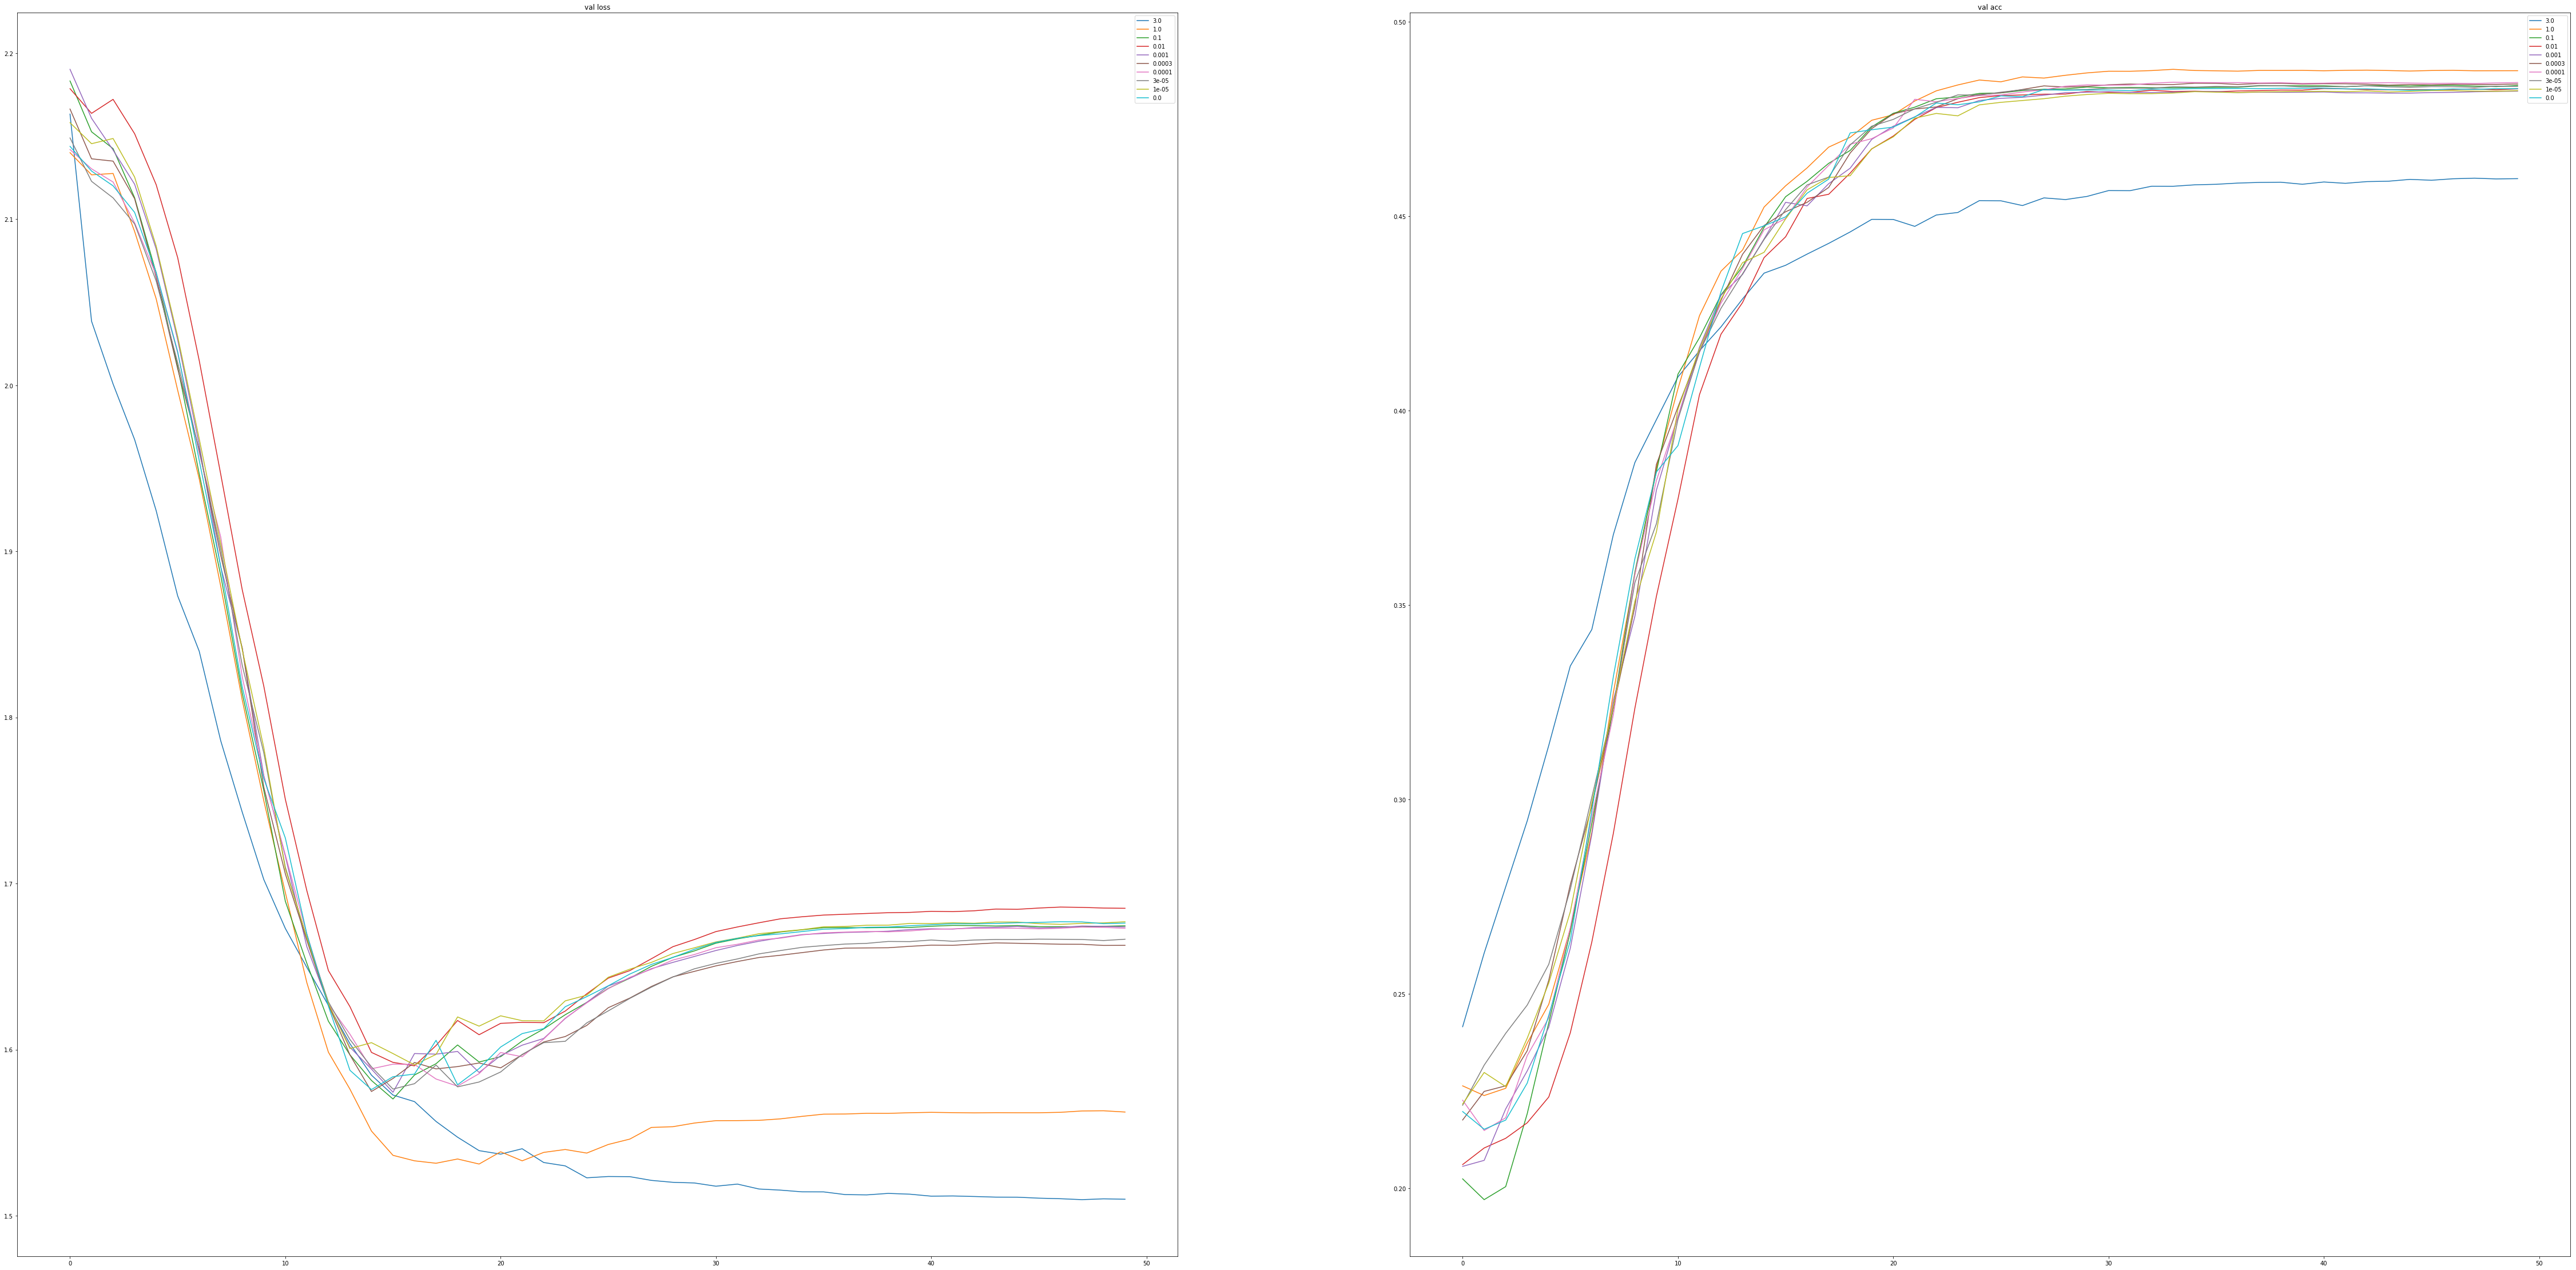

In [11]:
fig, axes = plt.subplots(1,2,figsize=(80,40))
av_histories = {}
for noisy, hist in zip(noises, histories):
    av_loss = None
    av_acc = None
    for history in histories[noisy]:
        if av_loss is None:
            av_loss = np.array(history['val_loss'])
        else:
            av_loss += np.array(history['val_loss'])
        if av_acc is None:
            av_acc = np.array(history['val_accuracy'])
        else:
            av_acc += np.array(history['val_accuracy'])
            
    av_loss /= LOOP
    av_acc /= LOOP
    axes[0].plot(av_loss, label=str(noisy))
    axes[0].set_title('val loss')
    axes[0].legend()
    axes[1].plot(av_acc, label=str(noisy))
    axes[1].set_title('val acc')
    axes[1].legend()
    
    av_histories[noisy] = {'av_loss':av_loss, 'av_acc':av_acc}
    

AttributeError: 'float' object has no attribute 'history'

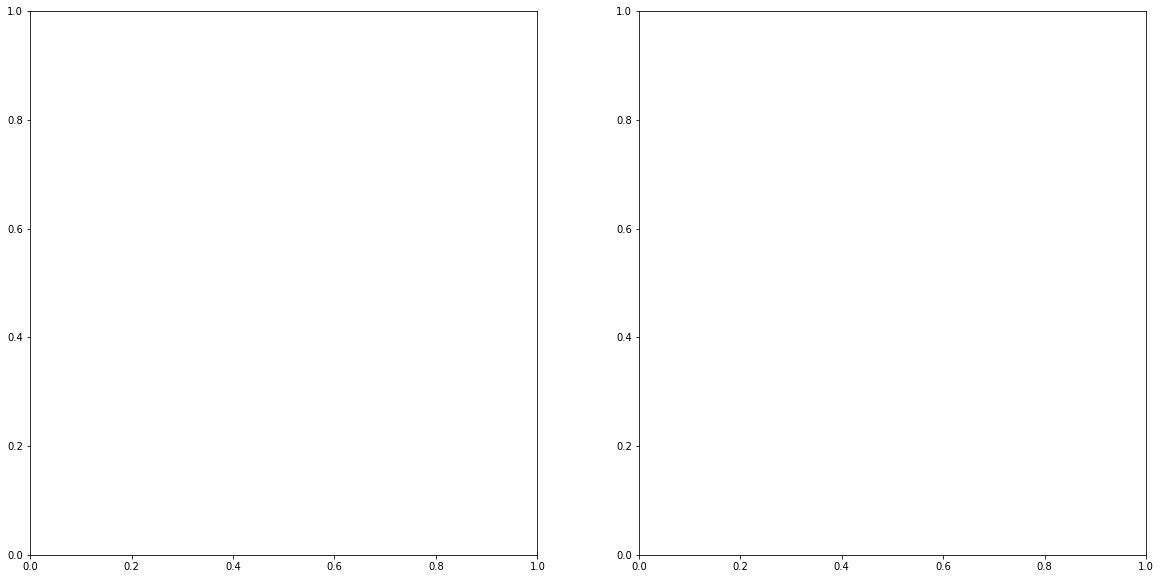

In [9]:
fig, axes = plt.subplots(1,2,figsize=(20,10))
for noisy, hist in zip(noises, histories):
    axes[0].plot(hist.history['loss'], label=str(noisy))
    axes[0].set_title('loss')
    axes[0].legend()
    axes[1].plot(hist.history['accuracy'], label=str(noisy))
    axes[1].set_title('acc')
    axes[1].legend()

In [12]:
# model 1
tf.keras.backend.clear_session()
# input_node = keras.layers.Input((28,28,1,))

# conv1 = keras.layers.Conv2D(32, (3,3),activation='relu')(input_node)
# batch1 = keras.layers.BatchNormalization()(conv1)
# pool1 = keras.layers.MaxPool2D((2,2))(batch1)

# conv2 = keras.layers.Conv2D(128, (3,3),activation='relu')(pool1)
# batch2 = keras.layers.BatchNormalization()(conv2)
# pool2 = keras.layers.MaxPool2D((2,2))(batch2)

# conv3 = keras.layers.Conv2D(256, (3,3),activation='relu')(pool2)
# batch3 = keras.layers.BatchNormalization()(conv3)
# pool3 = keras.layers.MaxPool2D((2,2))(batch3)

# av1 = keras.layers.GlobalAveragePooling2D()(pool3)

# h1 = keras.layers.Dense(512)(av1)
# batch4 = keras.layers.BatchNormalization()(h1)
# relu1 = keras.layers.Activation('relu')(batch4)

# output_h = tf.keras.layers.Dense(10)(relu1)
# output = tf.keras.layers.Activation('softmax')(output_h)

# model1 = keras.Model(input_node, output)

noise = 0.001

feature_layers = [
    keras.layers.Conv2D(32,(2,2),padding='valid',activation='relu',input_shape=(28,28,1)),
    NoisyBatchNormalization(noise),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(128,(2,2),padding='valid',activation='relu'),
    NoisyBatchNormalization(noise),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten()
]

classify_layer = [
    keras.layers.Dense(128,activation='relu'),
    NoisyBatchNormalization(noise),
    keras.layers.Dense(64,activation='relu'),
    NoisyBatchNormalization(noise),
    keras.layers.Dense(10,activation='softmax')
]

model = keras.models.Sequential(feature_layers + classify_layer)



In [13]:
# model1 = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10)
lr_reduce = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
callbacks = [early_stop, lr_reduce]

history2 = model.fit_generator(train_gen, 
                    epochs=100,
                    validation_data=val_gen, 
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/100
600/600 [==============================] - 24s 41ms/step - loss: 0.3713 - accuracy: 0.8686 - val_loss: 0.4238 - val_accuracy: 0.8478
Epoch 2/100
600/600 [==============================] - 21s 35ms/step - loss: 0.2577 - accuracy: 0.9057 - val_loss: 0.2881 - val_accuracy: 0.8947
Epoch 3/100
600/600 [==============================] - 21s 35ms/step - loss: 0.2201 - accuracy: 0.9184 - val_loss: 0.2648 - val_accuracy: 0.9039
Epoch 4/100
600/600 [==============================] - 21s 35ms/step - loss: 0.1982 - accuracy: 0.9276 - val_loss: 0.2498 - val_accuracy: 0.9043
Epoch 5/100
600/600 [==============================] - 21s 35ms/step - loss: 0.1797 - accuracy: 0.9342 - val_loss: 0.2851 - val_accuracy: 0.8981
Epoch 6/100
600/600 [==============================] - 21s 35ms/step - loss: 0.1627 - accuracy: 0.9403 - val_loss: 0.3854 - val_accuracy: 0.8788
Epoch 7/100
600/600 [==============================] - 21s 35ms/step - loss: 0.1238 - accuracy: 0.9557 - val_loss: 0.2058 - val_ac

In [10]:
# model1 = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10)
lr_reduce = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
callbacks = [early_stop, lr_reduce]

history2 = model.fit_generator(train_gen, 
                    epochs=100,
                    validation_data=val_gen, 
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/100
600/600 [==============================] - 25s 41ms/step - loss: 0.3692 - accuracy: 0.8693 - val_loss: 0.3114 - val_accuracy: 0.8909
Epoch 2/100
600/600 [==============================] - 21s 35ms/step - loss: 0.2507 - accuracy: 0.9086 - val_loss: 0.3024 - val_accuracy: 0.8849
Epoch 3/100
600/600 [==============================] - 21s 35ms/step - loss: 0.2178 - accuracy: 0.9192 - val_loss: 0.3650 - val_accuracy: 0.8715
Epoch 4/100
600/600 [==============================] - 21s 35ms/step - loss: 0.1952 - accuracy: 0.9278 - val_loss: 0.2479 - val_accuracy: 0.9143
Epoch 5/100
600/600 [==============================] - 21s 34ms/step - loss: 0.1737 - accuracy: 0.9358 - val_loss: 0.2386 - val_accuracy: 0.9115
Epoch 6/100
600/600 [==============================] - 21s 35ms/step - loss: 0.1568 - accuracy: 0.9429 - val_loss: 0.2652 - val_accuracy: 0.9093
Epoch 7/100
600/600 [==============================] - 21s 34ms/step - loss: 0.1453 - accuracy: 0.9456 - val_loss: 0.2324 - val_ac

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 27, 27, 32)        160       
_________________________________________________________________
noisy_batch_normalization (N (None, 27, 27, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 128)       16512     
_________________________________________________________________
noisy_batch_normalization_1  (None, 12, 12, 128)       512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0

In [108]:
model.layers[-3].alpha

0.0

In [109]:
test_sample = (test_images[0:1] - val_datagen.mean) / val_datagen.std

In [113]:
model(test_sample, True), model(test_sample, True)

(<tf.Tensor: id=2501654, shape=(1, 10), dtype=float32, numpy=
 array([[0.13843529, 0.05150985, 0.13164458, 0.10711217, 0.11896749,
         0.0642731 , 0.19018374, 0.06787579, 0.05859613, 0.07140175]],
       dtype=float32)>,
 <tf.Tensor: id=2501922, shape=(1, 10), dtype=float32, numpy=
 array([[0.13829191, 0.05077892, 0.1490697 , 0.08513884, 0.11786278,
         0.05966897, 0.22854039, 0.05467411, 0.0611936 , 0.05478082]],
       dtype=float32)>)

In [ ]:
test_pre = keras.layers.Lambda(lambda x: tf.expand_dims(tf.cast(x, tf.float32) / 255., axis=-1))
test_conv = keras.layers.Conv2D(32, (3,3))

In [23]:
x = train_images[:3]
mid = test_pre(x)
out = test_conv(mid)

In [7]:
# model 2
tf.keras.backend.clear_session()
# input_node = keras.layers.Input((28,28))
# expand = keras.layers.Lambda(lambda x: tf.expand_dims(tf.cast(x, tf.float32) / 255., axis=-1))(input_node)

# conv1 = keras.layers.Conv2D(32, (3,3))(expand)
# batch1 = NoisyBatchNormalization(0)(conv1)
# pool1 = keras.layers.MaxPool2D((2,2))(batch1)

# conv2 = keras.layers.Conv2D(32, (3,3))(pool1)
# batch2 = NoisyBatchNormalization(0)(conv2)
# pool2 = keras.layers.MaxPool2D((2,2))(batch2)

# conv3 = keras.layers.Conv2D(32, (3,3))(pool2)
# batch3 = NoisyBatchNormalization(0)(conv3)
# pool3 = keras.layers.MaxPool2D((2,2))(batch3)

# av1 = keras.layers.GlobalAveragePooling2D()(pool3)

# h1 = keras.layers.Dense(512)(av1)
# batch4 = NoisyBatchNormalization(0)(h1)
# relu1 = keras.layers.Activation('relu')(batch4)

# output_h = tf.keras.layers.Dense(10, act)(relu1)
# output = tf.keras.layers.Activation('softmax')(output_h)


class PreProcess(keras.layers.Layer):
    def call(self, inputs):
        return tf.expand_dims(tf.cast(inputs, tf.float32) / 255., axis=-1)

class MyModel(keras.Model):
    def __init__(self, alpha):
        super(MyModel, self).__init__()
        
        self.pre_pro = PreProcess()
        
        self.conv1 = keras.layers.Conv2D(32, (3,3),data_format='channels_last')
        self.conv2 = keras.layers.Conv2D(32, (3,3))
        self.conv3 = keras.layers.Conv2D(32, (3,3))
        
        self.batch1 = NoisyBatchNormalization(alpha)
        self.batch2 = NoisyBatchNormalization(alpha)
        self.batch3 = NoisyBatchNormalization(alpha)
        self.batch4 = NoisyBatchNormalization(alpha)
        
        self.pool = keras.layers.MaxPool2D((2,2))
        
        self.globalav = keras.layers.GlobalAveragePooling2D()
        
        self.dense1 = keras.layers.Dense(512)
        self.dense2 = keras.layers.Dense(10, activation='softmax')
        self.relu1 = keras.layers.Activation('relu')
        
    def call(self, inputs, training=None):
        
        pro_inp = self.pre_pro(inputs)
        
        conv1 = self.conv1(pro_inp)
        batch1 = self.batch1(conv1, training)
        pool1 = self.pool(batch1)
        
        conv2 = self.conv2(pool1)
        batch2 = self.batch2(conv2, training)
        pool2 = self.pool(batch2)

        
        conv3 = self.conv3(pool2)
        batch3 = self.batch3(conv3, training)
        pool3 = self.pool(batch3)
        
        av = self.globalav(pool3)
        
        dense1 = self.dense1(av)
        batch4 = self.batch4(dense1, training)
        relu1 = self.relu1(batch4)
        
        pred = self.dense2(relu1)
        
        return pred
        


In [11]:
model = get_model(noisy=True, alpha=0.01)

In [9]:
_ = model(train_images[1:2])

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10)
lr_reduce = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1)
callbacks = [early_stop, lr_reduce]

from tensorflow.keras.utils import to_categorical
history = model.fit(train_images, to_categorical(train_labels), 
                    batch_size=32, epochs=100,
                    validation_data=(test_images, to_categorical(test_labels)), 
                    verbose=1, shuffle=False,
                    callbacks=callbacks)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 28s 467us/sample - loss: 0.5116 - accuracy: 0.8140 - val_loss: 0.4749 - val_accuracy: 0.8255
Epoch 2/100
60000/60000 [==============================] - 28s 463us/sample - loss: 0.3843 - accuracy: 0.8600 - val_loss: 0.4677 - val_accuracy: 0.8344
Epoch 3/100
60000/60000 [==============================] - 28s 461us/sample - loss: 0.3410 - accuracy: 0.8748 - val_loss: 0.4240 - val_accuracy: 0.8500
Epoch 4/100
60000/60000 [==============================] - 28s 461us/sample - loss: 0.3118 - accuracy: 0.8868 - val_loss: 0.4265 - val_accuracy: 0.8477
Epoch 5/100
60000/60000 [==============================] - 27s 457us/sample - loss: 0.2875 - accuracy: 0.8954 - val_loss: 0.4481 - val_accuracy: 0.8416
Epoch 6/100
60000/60000 [==============================] - 27s 458us/sample - loss: 0.2675 - accuracy: 0.9030 - val_loss: 0.4290 - val_accuracy: 0.8499
Epoch 7/100
60000/60000 [=============

KeyboardInterrupt: 

In [20]:
preds = np.zeros((10000, 10))

for i in range(int(10000 / 32) + 1):
    preds[i*32:(i+1)*32] = model(test_images[i*32:(i+1)*32], training=False).numpy()


In [21]:
np.mean((np.argmax(preds, axis=-1) - test_labels) == 0)

0.5659

In [9]:
test_labels

array([9, 2, 1, ..., 8, 1, 5], dtype=uint8)

In [ ]:
tf.keras.layers.BatchNormalization()

In [16]:
class TestLayer(tf.keras.layers.Layer):
    def __init__(self, units, input_dim):
        super(TestLayer, self).__init__()
        self.w = self.add_weight(shape=(input_dim, units),
                             initializer=tf.zeros_initializer,
                             trainable=True)
        
        
    def call(self, inputs, training=None):
        self.w = self.w + 1
        return inputs

In [17]:
test_layer = TestLayer(32, 32)

In [18]:
input_const = tf.constant([1,2,3])
output_const = test_layer(input_const)

In [19]:
test_layer.w

<tf.Tensor: id=26, shape=(32, 32), dtype=float32, numpy=
array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)>